In [1]:
# Tag each problem with tags listed in leetcode but not present in Hackerrank
import pandas as pd
import openai

# Function to fetch tags using OpenAI API
def fetch_tags(description, tags_list):
    try:
        response = openai.Completion.create(
            model="gpt-3.5-turbo",  # Adjust to the latest available model
            prompt=f"Given the following Java code, identify the top 10 most relevant programming tags from this list: {tags_list}\n\nJava Solution:\n{description}. Provide the response as a comma separated string of tags, with no other explanation.",
            max_tokens=150  # Adjust based on need
        )
        # Assuming the response will be a comma-separated string of tags
        return response.choices[0].text.strip().split(', ')
    except openai.error.OpenAIError as e:
        print(f"An error occurred: {e}")
        return []

# Set your OpenAI API key


# Tags from the image
tags_list = [
    "Array", "String", "Hash Table", "Math", "Dynamic Programming", "Sorting", "Greedy",
    "Depth-First Search", "Database", "Binary Search", "Breadth-First Search", "Tree", "Matrix",
    "Bit Manipulation", "Two Pointers", "Binary Tree", "Heap (Priority Queue)", "Prefix Sum",
    "Stack", "Simulation", "Graph", "Design", "Counting", "Sliding Window", "Backtracking",
    "Union Find", "Enumeration", "Linked List", "Ordered Set", "Monotonic Stack", "Trie",
    "Number Theory", "Divide and Conquer", "Recursion", "Bitmask", "Queue", "Binary Search Tree",
    "Segment Tree", "Memoization", "Geometry", "Hash Function", "Binary Indexed Tree",
    "Topological Sort", "String Matching", "Combinatorics", "Rolling Hash", "Shortest Path",
    "Game Theory", "Interactive", "Data Stream", "Brainteaser", "Monotonic Queue", "Randomized",
    "Merge Sort", "Iterator", "Concurrency", "Doubly-Linked List", "Probability and Statistics",
    "Quicksort", "Bucket Sort", "Suffix Array", "Minimum Spanning Tree", "Counting Sort", "Shell",
    "Line Sweep", "Reservoir Sampling", "Strongly Connected Component", "Eulerian Circuit",
    "Radix Sort", "Rejection Sampling", "Biconnected Component"
]

# Load the CSV file
def load_and_tag_csv(filepath):
    df = pd.read_csv(filepath)
    df['Tags'] = df['LEAST'].apply(lambda x: fetch_tags(x, tags_list))
    return df

# Save the DataFrame with tags back to CSV
def save_csv(df, filepath):
    df.to_csv(filepath, index=False)

# Main function to process the CSV file
def process_csv(input_filepath, output_filepath):
    df = load_and_tag_csv(input_filepath)
    save_csv(df, output_filepath)

# Replace 'input.csv' and 'output_with_tags.csv' with your file paths.
process_csv('final_merged.csv', 'final_merged_with_tags.csv')

An error occurred: This model's maximum context length is 4097 tokens, however you requested 6430 tokens (6280 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 5513 tokens (5363 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 8421 tokens (8271 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 4515 tokens (4365 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 4540 tokens (4390 in your prompt; 150 for the completion). Please reduce your prompt; or completion len

KeyboardInterrupt: 

In [13]:
# Generate the one-shot and few-shot prompts. 
# Few shot prompts examples are added by intersecting the tags of the current problem with the tags of all the other problems and adding 
# the example with the most intersections.
import pandas as pd
import openai

# Set your OpenAI API key

def string_to_list(tag_string):
    # Handle None values and empty strings
    if not tag_string or pd.isna(tag_string):
        return []
    # Split the string on comma and strip whitespace from each tag
    return [tag.strip() for tag in tag_string.split(',')]

def fetch_response(prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that provides the most optimized Java code solutions."},
                {"role": "user", "content": prompt}
            ]
        )
        # Assuming the code output is the content of the last message from the assistant
        return response['choices'][0]['message']['content']
    except Exception as e:  # General exception handling, consider logging or more specific exception handling
        print(f"An error occurred: {e}")
        return "ERROR: Could not generate a response"

def split_and_find_matches(df):
    # Convert the string of tags into a list
    df['Tags'] = df['Tags'].apply(string_to_list)

    def count_matching_tags(tags1, tags2):
        set1 = set(tags1)
        set2 = set(tags2)
        return len(set1.intersection(set2))

    results = []

    for index, row in df.iterrows():
        # Calculate matching tags with all other rows
        df['MatchingTags'] = df['Tags'].apply(lambda x: count_matching_tags(x, row['Tags']))
        # Find the row with the maximum number of matching tags
        max_matching_index = df['MatchingTags'].idxmax()
        best_match = df.iloc[max_matching_index]

        # Construct few-shot and one-shot prompts
        prompt_fewshot = (
            f"This is a Java code block, referred to as code1, that has a slow algorithmic time complexity.\n"
            f"code1: {row['LEAST']}\n"
            f"I want you to optimize code1 above such that the new code is more time efficient and accomplishes the same tasks as code1. "
            f"I don't want you to give me any explanation, just return the newly generated code.\n"
            f"To assist you, I am providing an example where a similar code block, code2, was optimized into code3. "
            f"Please apply a similar optimization approach to code1 as demonstrated in the transformation from code2 to code3, focusing on improving time efficiency.\n"
            f"code2: {best_match['LEAST']}\n"
            f"code3: {best_match['BEST']}\n"
        )

        prompt_oneshot = (
            f"This is a Java code block, referred to as code1, that has a slow algorithmic time complexity.\n"
            f"code1: {row['LEAST']}\n"
            f"I want you to optimize code1 above such that the new code is more time efficient and accomplishes the same tasks as code1. "
            f"I don't want you to give me any explanation, just return the newly generated code.\n"
        )

        few_shot_response = fetch_response(prompt_fewshot)

        results.append({
            'One Shot Prompt': prompt_oneshot,
            'Few Shot Prompt': prompt_fewshot,
            'Few Shot Response': few_shot_response
        })

    # Create a DataFrame with the results
    prompts_df = pd.DataFrame(results)
    final_df = pd.concat([df.reset_index(drop=True), prompts_df], axis=1)

    return final_df

# Load the data
df = pd.read_csv('final_merged_with_tags.csv')

# Generate the DataFrame with prompts
test_df_with_prompts = split_and_find_matches(df)

# Save to CSV
output_csv_path = 'final_merged_with_prompts.csv'
test_df_with_prompts.to_csv(output_csv_path, index=False)

In [3]:
# Make the LLM generate test cases for the best and few shot java code results, compare the actual run time, and produce the comparison 
# result as BEST or FEW-SHOT and the second comparsion as FEW-SHOT or LEAST
def fetch_response_1(best_code, few_shot_code):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that compares Java code solutions by generating a test case that can be used by both solutions, tracking the time it takes to run each of the solutions with the test case and then giving one response: BEST or FEW-SHOT stating which performs better."},
                 {"role": "user", "content": f"Compare the following two Java solutions and determine which one performs better. Solution 1 (BEST): {best_code} Solution 2 (FEW-SHOT): {few_shot_code}. Only give me the result: Whether it is FEW-SHOT or BEST, I want no other explanation."}
            ]
        )
        # Assuming the code output is the content of the last message from the assistant
        return response['choices'][0]['message']['content']
    except Exception as e:  # General exception handling, consider logging or more specific exception handling
        print(f"An error occurred: {e}")
        return "ERROR: Could not generate a response"

def fetch_response_2(few_shot_code, least_code):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that compares Java code solutions by generating a test case that can be used by both solutions, tracking the time it takes to run each of the solutions with the test case and then giving one response: FEW-SHOT or LEAST stating which performs better."},
                 {"role": "user", "content": f"Compare the following two Java solutions and determine which one performs better. Solution 1 (FEW-SHOT): {few_shot_code} Solution 2 (LEAST): {least_code}. Only give me the result: Whether it is FEW-SHOT or LEAST, I want no other explanation."}
            ]
        )
        # Assuming the code output is the content of the last message from the assistant
        return response['choices'][0]['message']['content']
    except Exception as e:  # General exception handling, consider logging or more specific exception handling
        print(f"An error occurred: {e}")
        return "ERROR: Could not generate a response"
        
def compare_execution_times(df):
    for index, row in df.iterrows():
        # Send the BEST and Few Shot Response code to OpenAI for comparison
        comparison_result_1 = fetch_response_1(row['BEST'], row['Few Shot Response'])
        # Send the BEST and Few Shot Response code to OpenAI for comparison
        comparison_result_2 = fetch_response_2(row['Few Shot Response'], row['LEAST']), 
        # Store the result in a new column
        df.at[index, 'Comparison Result - BEST vs FEW-SHOT'] = comparison_result_1
        df.at[index, 'Comparison Result - FEW-SHOT vs LEAST'] = comparison_result_2
    return df

def process_csv(file_path):
    df = pd.read_csv(file_path)
    updated_df = compare_execution_times(df)
    updated_file_path = 'updated_' + file_path
    updated_df.to_csv(updated_file_path, index=False)
    return updated_file_path

# Run the process on your CSV file
process_csv('final_merged_with_prompts.csv')

'updated_final_merged_with_prompts.csv'

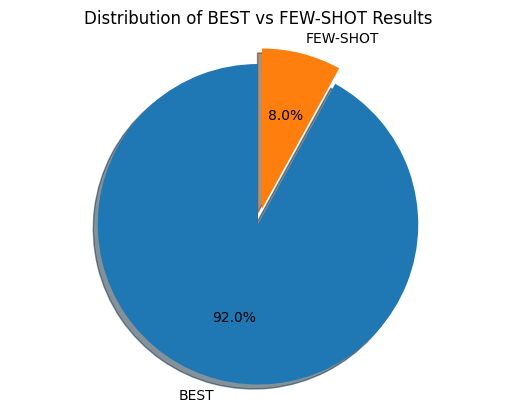

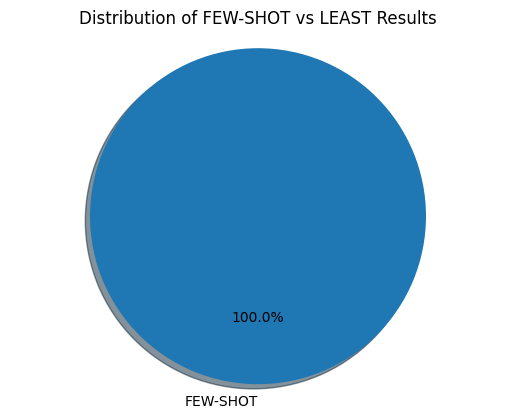

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def clean_comparison_results(value):
    """ Extract the main content from the tuple-like string. """
    match = re.search(r"\('([^']*)',", value)
    return match.group(1) if match else value

def analyze_results(file_path):
    """ Read and process the CSV file to count outcomes from comparison results. """
    df = pd.read_csv(file_path)
    df['Comparison Result - BEST vs FEW-SHOT'] = df['Comparison Result - BEST vs FEW-SHOT'].fillna('')
    df['Comparison Result - FEW-SHOT vs LEAST'] = df['Comparison Result - FEW-SHOT vs LEAST'].fillna('').apply(clean_comparison_results)

    result_counts_best_fewshot = df['Comparison Result - BEST vs FEW-SHOT'].value_counts()
    result_counts_fewshot_least = df['Comparison Result - FEW-SHOT vs LEAST'].value_counts()

    return result_counts_best_fewshot, result_counts_fewshot_least

def create_pie_charts(result_counts_best_fewshot, result_counts_fewshot_least):
    """ Create and display pie charts for the comparison results. """
    # Pie chart for BEST vs FEW-SHOT
    labels_best_fewshot = result_counts_best_fewshot.index
    sizes_best_fewshot = result_counts_best_fewshot.values
    explode_best_fewshot = [0.1 if label == 'BEST' else 0 for label in labels_best_fewshot]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes_best_fewshot, explode=explode_best_fewshot, labels=labels_best_fewshot, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.title('Distribution of BEST vs FEW-SHOT Results')

    # Pie chart for FEW-SHOT vs LEAST
    labels_fewshot_least = result_counts_fewshot_least.index
    sizes_fewshot_least = result_counts_fewshot_least.values
    explode_fewshot_least = [0.1 if label == 'FEW-SHOT' else 0 for label in labels_fewshot_least]

    fig2, ax2 = plt.subplots()
    ax2.pie(sizes_fewshot_least, explode=explode_fewshot_least, labels=labels_fewshot_least, autopct='%1.1f%%', shadow=True, startangle=90)
    ax2.axis('equal')
    plt.title('Distribution of FEW-SHOT vs LEAST Results')

    plt.show()

# Main execution block
file_path = 'updated_final_merged_with_prompts.csv'
result_counts_best_fewshot, result_counts_fewshot_least = analyze_results(file_path)
create_pie_charts(result_counts_best_fewshot, result_counts_fewshot_least)
